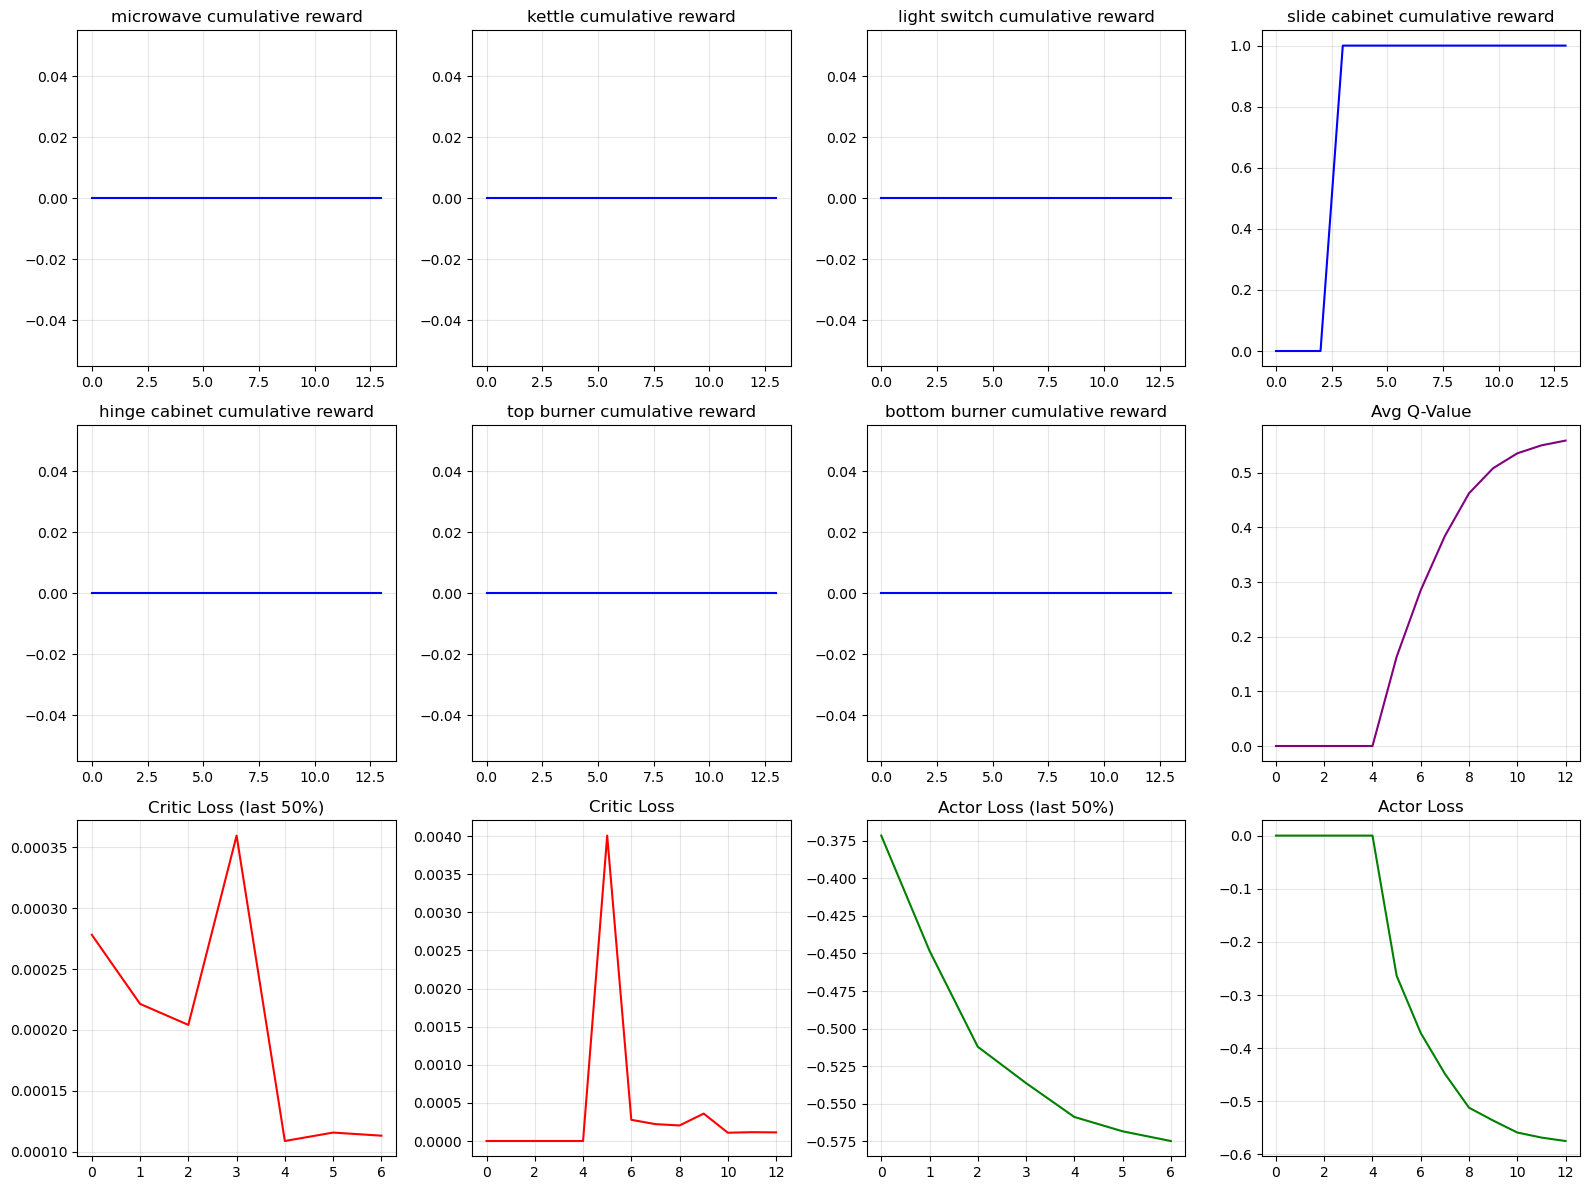

Loading checkpoint: checkpoints/checkpoint_10.pth
Resumed successfully from Episode 11
State Dim: 59, Goal Dim: 17, OHE Dim: 7
Running On Device: cuda
Ep 11: Solved [] | Loss: 0.00011 | Buffer: 21671 | Unsolved: microwave
Ep 12: Solved [] | Loss: 0.00012 | Buffer: 23671 | Unsolved: top burner
Ep 13: Solved [] | Loss: 0.00011 | Buffer: 25671 | Unsolved: hinge cabinet


KeyboardInterrupt: 

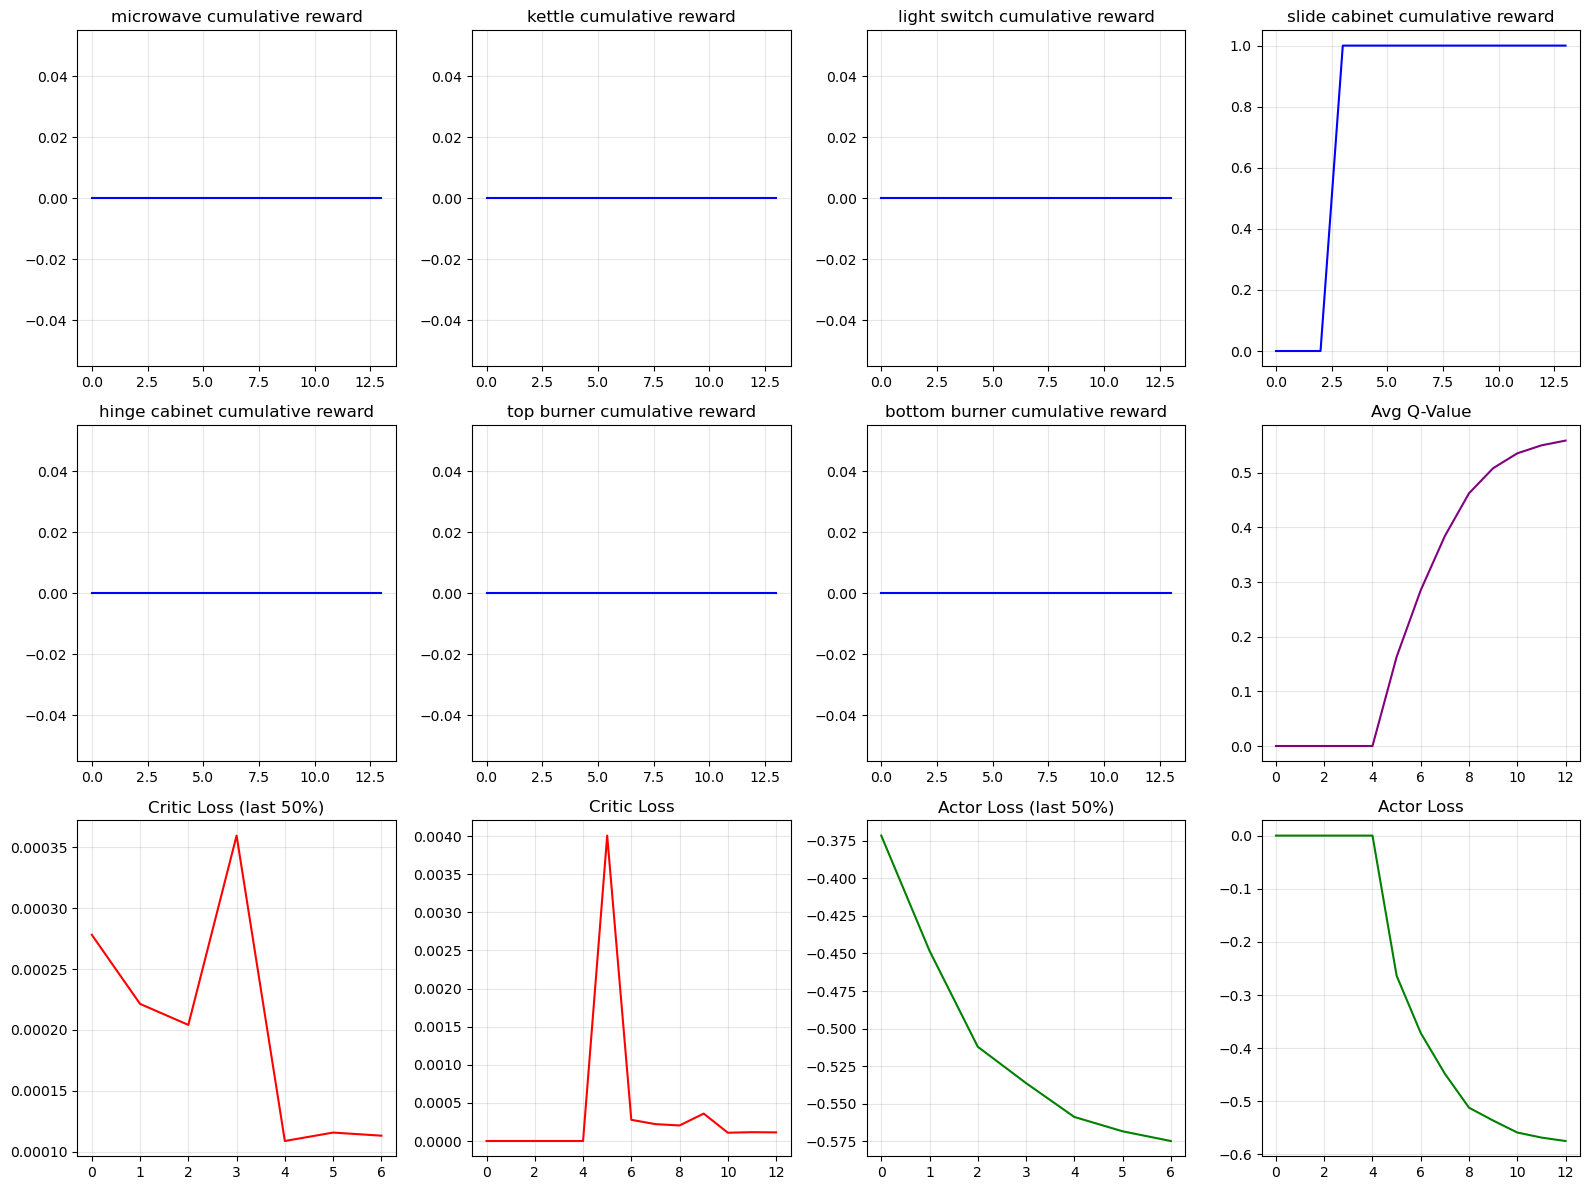

In [1]:
import torch
import numpy as np
import gymnasium_robotics
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
import random
import os
from utils.functions import ohe_goals, flatten_info
from utils.agent import DDPGAgent
from utils.replay_buffer import ReplayBuffer

SEED = 42
task_rng = np.random.default_rng(SEED)
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False 
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.use_deterministic_algorithms(True, warn_only=True)

ENV_NAME = 'FrankaKitchen-v1' 
MAX_EPISODES = 20000
MAX_STEPS = 1000
BATCH_SIZE = 1024
START_TRAINING_AFTER = 5000
NOISE = 0.05
K = 1

CHECKPOINT_FREQ = 5
PLOT_FREQ = 1
RESUME_PATH = "checkpoints/checkpoint_10.pth"
CHECKPOINT_DIR = "checkpoints"

TASKS = ['microwave', 'kettle', 'light switch', 'slide cabinet', 'hinge cabinet', 'top burner', 'bottom burner']

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

env = gym.make(ENV_NAME, max_episode_steps=MAX_STEPS, tasks_to_complete=TASKS)
env.action_space.seed(SEED)
obs_dict = env.reset()[0]
state_dim = obs_dict['observation'].shape[0]
action_dim = env.action_space.shape[0]
sample_goal = np.concatenate([obs_dict["desired_goal"][k] for k in TASKS])
goal_dim = sample_goal.shape[0]
ohe_dim = len(TASKS)

OHE_LOOKUP = ohe_goals(TASKS)
device = "cuda"

replay_buffer = ReplayBuffer(state_dim, action_dim, ohe_dim, goal_dim, device,max_size=50_000, seed=SEED)
agent = DDPGAgent(state_dim, action_dim, ohe_dim, goal_dim, device)


task_history = {task: [0] for task in TASKS}
cumulative_victories = {task: 0 for task in TASKS}

loss_history = {
    "critic_loss": [],
    "actor_loss": []
}

q_value_history = []

efficiency_history = {task: [] for task in TASKS}

start_episode = 1
total_steps = 0

plot_display = display.display(plt.figure(figsize=(16, 12)), display_id=True)

MAX_NOISE = 0.01
MIN_NOISE = 0
CYCLE_LENGTH = 500
PARAMETER_NOISE = True

if RESUME_PATH is not None and os.path.exists(RESUME_PATH):
    print(f"Loading checkpoint: {RESUME_PATH}")
    checkpoint = torch.load(RESUME_PATH, weights_only=False)
    
    agent.actor.load_state_dict(checkpoint["actor_state_dict"])
    agent.actor_target.load_state_dict(checkpoint["actor_target_state_dict"])
    agent.perturbed_actor.load_state_dict(checkpoint["actor_pertrubed_state_dict"])

    agent.critic.load_state_dict(checkpoint["critic_state_dict"])
    agent.critic_target.load_state_dict(checkpoint["critic_target_state_dict"])

    agent.actor_optimizer.load_state_dict(checkpoint["actor_optimizer_state_dict"])
    agent.critic_optimizer.load_state_dict(checkpoint["critic_optimizer_state_dict"])
    
    task_history = checkpoint["task_history"]
    cumulative_victories = checkpoint["cumulative_reward"]

    loss_history = checkpoint["loss_history"]
    q_value_history = checkpoint["q_value_history"]
    efficiency_history = checkpoint["efficiency_history"]
    
    total_steps = checkpoint["total_steps"]
    start_episode = checkpoint["episode"] + 1
    replay_buffer = checkpoint["replay_buffer"]
    print(f"Resumed successfully from Episode {start_episode}")

print(f"State Dim: {state_dim}, Goal Dim: {goal_dim}, OHE Dim: {ohe_dim}")
print(f"Running On Device: {device}")



for episode in range(start_episode, MAX_EPISODES):
    
    cycle_progress = (episode % CYCLE_LENGTH) / CYCLE_LENGTH
    cos_val = 0.5 * (1 + np.cos(cycle_progress * np.pi))
    current_noise = MIN_NOISE + (MAX_NOISE - MIN_NOISE) * cos_val
    agent.perturb_policy(noise_scale=current_noise)
    
    raw_state, _ = env.reset(seed=SEED)
    state, achieved_goal, desired_goal = flatten_info(raw_state, TASKS)
    
    episode_cache = []
    victory_map = {}
    current_start_index = 0
    undone_tasks = list(TASKS)

    ep_critic_losses = []
    ep_actor_losses = []
    ep_q_values = []
    
    current_task_name = task_rng.choice(undone_tasks)
    current_ohe = OHE_LOOKUP[current_task_name]
    generic_task_ohe = np.zeros(ohe_dim) 
    
    for step in range(MAX_STEPS):
        
        action = agent.select_action(state, current_ohe, desired_goal, noise=NOISE, use_parameter_noise=PARAMETER_NOISE)

        next_raw_state, reward, terminated, truncated, info = env.step(action)
        next_state, next_achieved, next_desired = flatten_info(next_raw_state, TASKS)
        
        episode_cache.append({
            'state': state,
            'action': action,
            'next_state': next_state,
            'achieved_goal': next_achieved, 
            'desired_goal': next_desired,   
        })
        
        if info["step_task_completions"]:
            for task_name in info["step_task_completions"]:
                if task_name not in victory_map:
                    victory_map[task_name] = step
                    
                    duration = step - current_start_index
                    efficiency_history[task_name].append(duration)

                    solved_ohe = OHE_LOOKUP[task_name]
                    for i in range(current_start_index, step + 1):
                        data = episode_cache[i]
                        is_finish = (i == step)
                        replay_buffer.add(
                            data['state'], 
                            data['action'], 
                            solved_ohe,
                            data['desired_goal'], 
                            data['next_state'],
                            reward=1 if is_finish else 0,
                            done=1 if is_finish else 0,
                        )
                    
                    current_start_index = step + 1
                    if task_name in undone_tasks: 
                        undone_tasks.remove(task_name)
                    
                    if undone_tasks:
                        current_task_name = task_rng.choice(undone_tasks)
                        current_ohe = OHE_LOOKUP[current_task_name]

        state = next_state
        total_steps += 1
        
        if total_steps > START_TRAINING_AFTER:
            for _ in range(K):
                c_loss, a_loss, q_val = agent.train(replay_buffer, BATCH_SIZE)
                ep_critic_losses.append(c_loss)
                ep_actor_losses.append(a_loss)
                ep_q_values.append(q_val)

        if terminated or truncated:
            break

    if current_start_index < len(episode_cache):
        final_achieved_goal = episode_cache[-1]['achieved_goal']

        for i in range(current_start_index, len(episode_cache)):
            data = episode_cache[i]
            is_last = (i == len(episode_cache) - 1)
            
            replay_buffer.add(
                data['state'], 
                data['action'], 
                generic_task_ohe,     
                final_achieved_goal,  
                data['next_state'],
                reward=1 if is_last else 0,
                done=1 if is_last else 0,
            )
        
            replay_buffer.add(
                data['state'], 
                data['action'], 
                current_ohe, 
                data['desired_goal'],
                data['next_state'],
                reward=0,
                done=0,
            )

    for task in TASKS:
        if task in victory_map:
            cumulative_victories[task] += 1
        task_history[task].append(cumulative_victories[task])
    

    if ep_critic_losses:
        loss_history["critic_loss"].append(np.mean(ep_critic_losses))
        loss_history["actor_loss"].append(np.mean(ep_actor_losses))
        q_value_history.append(np.mean(ep_q_values))
    else:
        loss_history["critic_loss"].append(0)
        loss_history["actor_loss"].append(0)
        q_value_history.append(0)

    if episode % PLOT_FREQ == 0:
        plt.clf()
        
        for i, task in enumerate(TASKS):
            plt.subplot(3, 4, i + 1)
            plt.plot(task_history[task], label="cumulative reward", color="blue")
            plt.title(f"{task} cumulative reward")
            plt.grid(True, alpha=0.3)

        plt.subplot(3, 4, 8) 
        plt.plot(q_value_history, color="purple")
        plt.title("Avg Q-Value")
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 4, 9)
        plt.plot(loss_history["critic_loss"][int(episode/2):], color="red")
        plt.title("Critic Loss (last 50%)")
        plt.grid(True, alpha=0.3)

        plt.subplot(3, 4, 10)
        plt.plot(loss_history["critic_loss"], color="red")
        plt.title("Critic Loss")
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 4, 11)
        plt.plot(loss_history["actor_loss"][int(episode/2):], color="green")
        plt.title("Actor Loss (last 50%)")
        plt.grid(True, alpha=0.3)

        plt.subplot(3, 4, 12)
        plt.plot(loss_history["actor_loss"], color="green")
        plt.title("Actor Loss")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plot_display.update(plt.gcf())

    if episode % CHECKPOINT_FREQ == 0:
        checkpoint_data = {
            "episode": episode,
            "actor_state_dict": agent.actor.state_dict(),
            "actor_target_state_dict": agent.actor_target.state_dict(),
            "actor_pertrubed_state_dict": agent.perturbed_actor.state_dict(),
            "critic_state_dict": agent.critic.state_dict(),
            "critic_target_state_dict": agent.critic_target.state_dict(),
            "actor_optimizer_state_dict": agent.actor_optimizer.state_dict(),
            "critic_optimizer_state_dict": agent.critic_optimizer.state_dict(),
            "task_history": task_history,
            "cumulative_reward": cumulative_victories, 
            "loss_history": loss_history,
            "efficiency_history": efficiency_history,
            "total_steps": total_steps,
            "replay_buffer": replay_buffer,
            "q_value_history": q_value_history
        }
        save_filename = f"{CHECKPOINT_DIR}/checkpoint_{episode}.pth"
        torch.save(checkpoint_data, save_filename)
        print(f"--> Checkpoint saved: {save_filename}")

    c_loss_print = round(loss_history["critic_loss"][-1], 5) if loss_history["critic_loss"] else 0
    print(f"Ep {episode}: Solved {list(victory_map.keys())} | Loss: {c_loss_print} | Buffer: {replay_buffer.size} | Unsolved: {current_task_name}")